#Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Libraries

In [3]:
import csv    
import os
import audioread
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
import math
import librosa,librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


#Defining functions

In [8]:
# Getting featues of the audio file
    
def features(file_name):
    audio,sample_rate=librosa.load(file_name,res_type='kaiser_fast')
    mfccs=librosa.feature.mfcc(audio,sr=22050,n_fft=2048,hop_length=512,n_mfcc=13)
    scaled_mfccs=np.mean(mfccs.T,axis=0)
    return scaled_mfccs

# reading all the datas from folder and extracting features

def readDataAccent(dataset_path,csv_file):
    metasa=pd.read_csv(csv_file)
    metasa.head()
    x_features=[]
    for i,row in metasa.iterrows():
    
        file_name=os.path.join(os.path.abspath(dataset_path),str(row["class"])+"/",str(row["filename"]))
        class_name=row["class"]
        data=features(file_name)
        x_features.append([data,class_name])
    return x_features



# Spliting values for test and train

def SplitValues(ex_features):
    data_frame=pd.DataFrame(ex_features,columns=['feature','class'])
    
    feature=np.array(data_frame['feature'].tolist())
    classes=np.array(data_frame['class'].tolist())
    classes=np.asarray(pd.get_dummies(classes))
    
    x_train,x_test,y_train,y_test = train_test_split(feature,classes,test_size=0.25)  
    x_train,x_valid,y_train,y_valid = train_test_split(feature,classes,test_size=0.20)
   
    x_train =x_train[...,np.newaxis]
    x_valid =x_valid[...,np.newaxis]
    x_test =x_test[...,np.newaxis]

    input_shape=(x_train.shape[1],x_train.shape[2])
    
    return x_train,x_valid, x_test, y_train, y_valid, y_test, input_shape


def readDataEmotion(dataset_path,csv_file):
    metasa=pd.read_csv(csv_file)
    metasa.head()
    x_features=[]
    for i,row in metasa.iterrows():
    
        file_name=os.path.join(os.path.abspath(dataset_path),str(row["class"])+"/",str(row["filename"]))
        emotion=str(row["emotion"])
        data=features(file_name)
        x_features.append([data,emotion])
    return x_features



def createModelEmotion(input_shape):
     #model creation
    model=keras.Sequential()

    #convo layer 1
    model.add(keras.layers.Conv1D(32,3,activation='relu',padding='same',input_shape=input_shape,name="layer_1c"))
    model.add(keras.layers.MaxPool1D(3, strides=2,padding='same' , name="layer_1m"))
    model.add(keras.layers.BatchNormalization(name="layer_1bn"))

    #convo layer 2
    model.add(keras.layers.Conv1D(32,3,padding='same',activation='relu', name="layer_2c"))
    model.add(keras.layers.MaxPool1D(3, strides=2,padding='same' , name="layer_2m"))
    model.add(keras.layers.BatchNormalization(name="layer_2bn"))

    #convo layer 3
    model.add(keras.layers.Conv1D(32,3,padding='same',activation='relu', name="layer_3c"))
    model.add(keras.layers.MaxPool1D(3, strides=2,padding='same', name="layer_3m"))
    model.add(keras.layers.BatchNormalization(name="layer_3bn"))

    #convo layer 4
    model.add(keras.layers.Conv1D(32,3,padding='same',activation='relu', name="layer_4c"))
    model.add(keras.layers.MaxPool1D(3, strides=2,padding='same', name="layer_4m"))
    model.add(keras.layers.BatchNormalization(name="layer_4bn"))

    #convo layer 5
    model.add(keras.layers.Conv1D(32,3,padding='same',activation='relu', name="layer_5c"))
    model.add(keras.layers.MaxPool1D(2, strides=2,padding='same', name="layer_5m"))
    model.add(keras.layers.BatchNormalization(name="layer_5bn"))

    #flatten the output layer and add some dense layer

    model.add(keras.layers.Flatten(name="layer_fl"))
    model.add(keras.layers.Dense(256,activation='relu',name="layer_d1"))
    model.add(keras.layers.Dense(128,activation='relu',name="layer_d2"))
    model.add(keras.layers.Dense(64,activation='relu',name="layer_d3"))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(6,activation='softmax',name="new_output"))
    
    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])
    
    print("model created sucessfully")
    
    return model



# Getting Accuracy of the model

def testModelAccuracy(model,x_test,y_test):
    test_error,test_accuracy=model.evaluate(x_test,y_test,verbose=0)
    print()
    print("Accuracy on test is: {}".format(test_accuracy))
    print()
    print("Error on test is: {}".format(test_error))
    print()

    
# plotting Accuracy and error

def PlotAccuracy(history):
    fig,axes = plt.subplots(2)

    axes[0].plot(history.history["accuracy"],label="train_accuracy")
    axes[0].plot(history.history["val_accuracy"],label="test_accuracy")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(loc="lower right")
    axes[0].set_ylabel("Accuracy eval")

    axes[1].plot(history.history["loss"],label="train_error")
    axes[1].plot(history.history["val_loss"],label="test_error")
    axes[1].set_ylabel("error")
    axes[1].set_ylabel("epoch")
    axes[1].legend(loc="upper right")
    axes[1].set_ylabel("error eval")

    plt.show()



#Reading audio files and Extracting features

In [5]:
# parameters ---------> (folder_name , csvfile_name)
ex_features_model_Emotion = readDataEmotion("/content/drive/MyDrive/Speech_Emotion_Analysis_TL/dataset" , "/content/drive/MyDrive/Speech_Emotion_Analysis_TL/dataset.csv")
print("Operation done")

Operation done


#Spliting values

In [6]:
model_Emotion_xtrain,model_Emotion_xvalid, model_Emotion_xtest,model_Emotion_ytrain,model_Emotion_yvalid, model_Emotion_ytest,input_shape_model_Emotion = SplitValues(ex_features_model_Emotion)

#Model creation

In [9]:
Model_Emotion=createModelEmotion(input_shape_model_Emotion)
Model_Emotion.summary()

model created sucessfully
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1c (Conv1D)            (None, 13, 32)            128       
_________________________________________________________________
layer_1m (MaxPooling1D)      (None, 7, 32)             0         
_________________________________________________________________
layer_1bn (BatchNormalizatio (None, 7, 32)             128       
_________________________________________________________________
layer_2c (Conv1D)            (None, 7, 32)             3104      
_________________________________________________________________
layer_2m (MaxPooling1D)      (None, 4, 32)             0         
_________________________________________________________________
layer_2bn (BatchNormalizatio (None, 4, 32)             128       
_________________________________________________________________
layer_3c (Conv1D)           

#Training Model

In [10]:
history_Model_Emotion = Model_Emotion.fit(model_Emotion_xtrain,model_Emotion_ytrain,validation_data=(model_Emotion_xvalid, model_Emotion_yvalid),verbose=1,epochs=150,batch_size=32)

Epoch 1/150
43/43 [==============================] - 3s 15ms/step - loss: 1.8040 - accuracy: 0.2085 - val_loss: 1.7902 - val_accuracy: 0.1603
Epoch 2/150
43/43 [==============================] - 0s 7ms/step - loss: 1.6949 - accuracy: 0.3017 - val_loss: 1.7826 - val_accuracy: 0.1633
Epoch 3/150
43/43 [==============================] - 0s 8ms/step - loss: 1.6116 - accuracy: 0.3455 - val_loss: 1.7605 - val_accuracy: 0.1837
Epoch 4/150
43/43 [==============================] - 0s 6ms/step - loss: 1.5722 - accuracy: 0.3550 - val_loss: 1.7245 - val_accuracy: 0.2653
Epoch 5/150
43/43 [==============================] - 0s 7ms/step - loss: 1.5245 - accuracy: 0.3550 - val_loss: 1.6730 - val_accuracy: 0.3207
Epoch 6/150
43/43 [==============================] - 0s 7ms/step - loss: 1.4850 - accuracy: 0.3899 - val_loss: 1.6182 - val_accuracy: 0.3732
Epoch 7/150
43/43 [==============================] - 0s 7ms/step - loss: 1.4873 - accuracy: 0.3899 - val_loss: 1.5633 - val_accuracy: 0.3761
Epoch 8/150


#Testing and saving models


Accuracy on test is: 0.6993007063865662

Error on test is: 0.9039827585220337



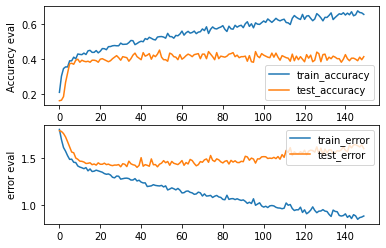

In [11]:
testModelAccuracy(Model_Emotion,model_Emotion_xtest,model_Emotion_ytest)
PlotAccuracy(history_Model_Emotion)

Model_Emotion.save("/content/drive/MyDrive/Speech_Emotion_Analysis_TL/savedModels/savedModelEmotion.h5")